# SST LST comparison at Dotson plume

In [1]:
# Import libraries and modules
%config InlineBackend.figure_format = 'svg'
%matplotlib widget
import pandas as pd
import xarray as xr
import geopandas as gpd
from datetime import date, timedelta, datetime
import numpy as np
import matplotlib.pylab as plt
from matplotlib import colors
from matplotlib.pylab import rcParams
import cartopy.crs as ccrs
import cartopy

import os
from cycler import cycler
import pyproj
from pyproj import Proj, transform
import gc
from pathlib import Path
from shapely.geometry import Point, Polygon

import earthaccess

import warnings
warnings.filterwarnings('ignore')

In [2]:
#For color cycling in plots that is color blind friendly...make new ones at "I want hue" tools.medialab.sciences-po.fr/iwanthue
color_cycler = cycler(color=["#6777cf","#adba49","#c65ca0","#5fa042","#683287","#72ce7b","#c44a48","#45c7a9","#933c1d","#d0803f","#ac9239","#317c39"])
colorline_cycler = (cycler(color=["#75a141","#6c61b9","#bc4d45","#c1913d","#b85298","#4aa8e8"]) +
                 cycler(linestyle=['-','--',':','-.','-','--']))
rcParams['axes.prop_cycle'] = cycler('color', color_cycler)

In [3]:
# Coefficients for calibration
# SST
sstcalib_m = 0.94 #ORD, 0.79 OLS
sstcalib_b = -0.08 #ORD, 0.73 OLS

# LST
lstcalib_m = 0.56
lstcalib_b = 0.37

modmin = -1.9
LSTmin = np.around(modmin/lstcalib_m - lstcalib_b,2) # should be about 2.0
SSTmin = np.around(modmin/sstcalib_m - sstcalib_b,2) # should be about 2.0

In [4]:
# Set paths and important variables
basepath = Path('/home/jovyan/Landsat_SST_algorithm')
sstpath = basepath / 'Data/SST/Validation/DotsonIntercomp/'
lstpath = basepath / 'Data/SST/LST/Calibration/DotsonPolynya'
figpath = basepath / 'Figures/'

In [5]:
# Bounding box
# bbox = (-101.98,-75.09,-101.65,-75.05) # PIG west plume based on Nov 06, 2014 Worldview image?
# bbox = (-101.98,-73.68,-101.31,-73.57) # Cosgrove plume based on Nov 06, 2014 Worldview image?
# bbox = (-101.48,-73.68,-101.31,-73.63) # Cosgrove plume based on Oct 19, 2019 Worldview image
Dbox = (-113.5,-74.20,-113.17,-74.11) # Dotson plume based on Nov 06, 2014 Worldview image?

## Build Landsat - MODIS SST matchups

In [6]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [7]:
def get_MODIS_SST(bbox,start_dt,end_dt):
    '''
    Finds the MODIS scene for a specified time and location 
    
    Variables: 
    bbox = 
    
    Outputs:
    mod_scene = xarray dataset of MODIS SST images
    file_list = list of file names
    '''
    
    # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
    granules = earthaccess.search_data(
        short_name='MODIS_T-JPL-L2P-v2019.0',
        bounding_box=bbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules2 = earthaccess.search_data(
        short_name='MODIS_A-JPL-L2P-v2019.0', #MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_NIGHTTIME_V2019.0
        bounding_box=bbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules = granules + granules2
    print (f'{len(granules)} TOTAL')
    
    file_list = []
    for granule in granules:
        file_list.append(granules['umm']['GranuleUR'])
        
    mod_scene = xr.open_mfdataset(earthaccess.open(granules)) #[0])
    mod_scene = mod_scene.rio.write_crs("epsg:4326", inplace=True) 
    
    return mod_scene, file_list

##########################

def subset_img(da,polarx,polary):
    '''
    Subset image in xarray to desired coordinates. Because Landsat polar stereo projection can be oriented
    in many different directions, when coordinates to subset an image are reprojected from lat/lon they may get 
    flipped for which is larger in the pair. This function checks to make sure we are getting a proper subset and 
    avoids 0 pixels on the x or y axis. 
    
    Note: Input shape dimensions and dataarray v. dataset changes things so input needs to be a dataarray w 
          2 dimensions (x,y)
    
    Input:
    da = xarray DataArray to be subset
    polarx = x coordinates to subset by in polar stereographic projection
    polary = y coordinates to subset by in polar stereographic projection
    
    Output:
    ls_sub = subset xarray DataArray
    
    '''
    # ***Landsat shape dimensions are one fewer than they are for LandsatCalibration [0,1] not [1,2], no .to_array() or Band
    ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))

    # Check for right dimensions because y order changes sometimes
    if (ls_sub.x.shape[0]==0) & (ls_sub.y.shape[0]==0):
        print ('L8 x and y shapes are 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[1],polarx[0]))
    elif ls_sub.y.shape[0]==0:
        print ('L8 y shape is 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[0],polarx[1]))
    elif ls_sub.x.shape[0]==0:
        print ('L8 x shape is 0')
        ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[1],polarx[0]))
    print(ls_sub.shape)
    
    return ls_sub

##########################

def lsat_reproj(old_cs,new_cs,lbox):
    '''
    bbox comes out with the points out of order for making a polygon though pairs are correct. Order is 0,3,1,2 when done in normal projection. 
    Haven't tested for flipped grid.
    '''
    
    test_threshold = 0.5
    
    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)
    
    ULX,LRY,LRX,ULY = lbox

    [lULX,lLRX], [lULY,lLRY] =  transform(inProj,outProj,[ULX,LRX], [ULY,LRY], always_xy=True)
    [cULX,cLRX], [cULY,cLRY] =  transform(outProj,inProj,[lULX,lLRX], [lULY,lLRY], always_xy=True)
    [lLLX,lURX], [lLLY,lURY] =  transform(inProj,outProj,[ULX,LRX], [LRY,ULY], always_xy=True)
    [cLLX,cURX], [cLLY,cURY] =  transform(outProj,inProj,[lLLX,lURX], [lLLY,lURY], always_xy=True)

    if LRY>ULY:
        bbox = [(lULX,lLLY),(lLLX,lULY),(lLRX,lURY),(lURX,lLRY)]
        print('lsat_reproj flipped orientation')
    else:
        bbox = [(lULX,lULY),(lLLX,lLLY),(lLRX,lLRY),(lURX,lURY)]
        print('lsat_reproj normal orientation')

    checkbox = np.array([cULX,cULY,cLRX,cLRY])
    if np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY])) > test_threshold:
        print(f"Round-trip transformation error 1 of {np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY]))}")
    checkbox = np.array([cLLX,cLLY,cURX,cURY])
    if np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY])) > test_threshold:
        print(f"Round-trip transformation error 2 of {np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY]))}")
    print (f'bbox={bbox}')
    print (f'lbox={lbox}')
    print (f'checkbox={checkbox}')
    
    return bbox,checkbox

##########################

def crop_xarray_dataarray_with_polygon(dataarray, polygon):
    """
    Crop an xarray.DataArray using a polygon.
    
    Parameters:
    - dataarray: xarray.DataArray with x and y coordinates.
    - polygon: Shapely Polygon object defining the crop area.
    
    Returns:
    - Cropped xarray.DataArray.
    """
    # Generate a 2D array of shapely Point objects for each grid point
    lon, lat = np.meshgrid(dataarray.x.values, dataarray.y.values)
    points = np.vectorize(Point)(lon, lat)
    
    # Create a mask where points within the polygon are True
    mask_func = np.vectorize(polygon.contains)
    mask = mask_func(points)
    
    # Convert the mask to an xarray.DataArray
    mask_da = xr.DataArray(mask, dims=["y", "x"], coords={"y": dataarray.y, "x": dataarray.x})
    
    # Apply the mask to the dataarray, cropping to the polygon
    # Use where method with drop=True to drop values outside the polygon
    cropped_dataarray = dataarray.where(mask_da, drop=True)
    
    return cropped_dataarray
    
##########################

# Preprocess to add time dimension and the file name to open_mfdataset for landsat using the filename
def add_time_dim(ds):
    lstr = ds.encoding["source"].split("LC0",1)[1]
    times = pd.to_datetime(lstr[14:22], format='%Y%m%d')
    idee = ds.encoding["source"].split("/")[8][:-4]
    return ds.assign_coords(time=times,ID=idee)

def add_time_dim_LST(ds):
    lstr = ds.encoding["source"].split("LC0",1)[1]
    times = pd.to_datetime(lstr[14:22], format='%Y%m%d')
    idee = ds.encoding["source"].split("/")[7][:-4]
    return ds.assign_coords(time=times,ID=idee)

In [8]:
# # Convert bounding box to polar for checking if landsat has any data in bounding box
# # Speeds up process a lot
# source_crs = 'epsg:4326' 
# target_crs = 'epsg:3031' # Coordinate system of the file

# topolar = pyproj.Transformer.from_crs(source_crs,target_crs)
# polarx,polary = topolar.transform([bbox[3],bbox[1]],[bbox[0],bbox[2]]) #LRX,LRY with ULX,ULY

# Convert bounding box to south polar stereo for checking if landsat has any data in bounding box
# Speeds up process a lot
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file

bbox,checkbox = lsat_reproj(source_crs,target_crs,(Dbox[0],Dbox[1],Dbox[2],Dbox[3]))

# Create polygon for later cropping
polygon = Polygon([(bbox[0][0],bbox[0][1]),(bbox[3][0],bbox[3][1]),(bbox[2][0],bbox[2][1]),(bbox[1][0],bbox[1][1])])

# Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
minx, miny, maxx, maxy = polygon.bounds
polarx = [minx, maxx]
polary = [miny, maxy]

lsat_reproj normal orientation
bbox=[(-1593109.0801169195, -692703.5426974659), (-1583974.6675212178, -688731.7870628558), (-1587915.183520055, -679597.3747787862), (-1597072.3201527703, -683516.4543874896)]
lbox=(-113.5, -74.2, -113.17, -74.11)
checkbox=[-113.5   -74.2  -113.17  -74.11]


In [9]:
# Get Landsat file paths in directory
lpath = sstpath

lsatfiles = os.listdir(lpath)
SSTfiles = [x for x in lsatfiles if x[-3:] == 'tif']

# Get Landsat file paths in directory
lpath = lstpath

lsatfiles = os.listdir(lpath)
LSTfiles = [x for x in lsatfiles if x[-3:] == 'TIF']

## SST and LST intercomparison

In [25]:
pairs = []

for SSTfile in SSTfiles:
    for LSTfile in LSTfiles:
        if SSTfile[:40]==LSTfile[:40]:
            pairs.append((SSTfile,LSTfile))
            continue

print (f'{len(pairs)} pairs')

42 pairs


In [62]:
%%time

sst = []

for pair in pairs:
    pair1 = pair[0]
    pair2 = pair[1]
    # Open SST and LST datasets and assign time and ID attributes
    sst_scene = xr.open_dataset(sstpath / pair1,chunks=dict(x=512, y=512),engine='rasterio')
    times = pd.to_datetime(pair1[17:25], format='%Y%m%d')
    sst_scene = sst_scene.assign_coords(time=times,ID=pair1)
    sst_scene = sst_scene.rio.write_crs("epsg:3031", inplace=True)
    SID = sst_scene.ID.values

    lst_scene = xr.open_dataset(lstpath / pair2,chunks=dict(x=512, y=512),engine='rasterio')
    lst_scene = lst_scene.assign_coords(time=times,ID=pair2)
    lst_scene = lst_scene.rio.write_crs("epsg:3031", inplace=True)
    LID = lst_scene.ID.values

    # Subset, QA and match LST pixels to SST
    sst_scene_sub = subset_img(sst_scene['band_data'].sel(band=1),polarx,polary)
    
    # Cross-calibrate to get absolute temps if needed
    sst_scene_sub = sst_scene_sub * sstcalib_m + sstcalib_b

    # QA - remove any pixels cooler than 1.9 because likely ice or cloud contaminated
    sst_scene_sub = sst_scene_sub.where(sst_scene_sub>-1.9)

    lst_scene_sub = subset_img(lst_scene['band_data'].sel(band=1),polarx,polary)
    lst_scene_sub = lst_scene_sub-273.15
    lst_scene_sub = lst_scene_sub.where(sst_scene_sub.notnull(),np.nan)

    # Cross-calibrate to get absolute temps if needed
    lst_scene_sub = lst_scene_sub * lstcalib_m + lstcalib_b

    # QA - remove any pixels cooler than 1.9 because likely ice or cloud contaminated
    lst_scene_sub = lst_scene_sub.where(lst_scene_sub>-1.9)

    # Take mean and count number of pixels used in the calculation
    try:
        lsatS = np.nanmean(sst_scene_sub)
        pixS = sst_scene_sub.notnull().sum().values

    except Exception as e:
        print (SID, e)
        lsat = np.nan

    try:
        lsatL = np.nanmean(lst_scene_sub)
        pixL = lst_scene_sub.notnull().sum().values

    except Exception as e:
        print (LID, e)
        lsat = np.nan

    # Append file names with each images ID, SST mean, datetime, and pixel count
    sst.append([times,SID,lsatS,pixS,LID,lsatL,pixL])
    print(f'SST: {lsatS}, LST: {lsatL}')

    try:
        del sst_scene, sst_scene_sub,lst_scene,lst_scene_sub
    except:
        pass

    gc.collect()

(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: -1.822169174879661, LST: -1.6455124616622925
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: -1.0035885048969668, LST: -1.2913826704025269
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST: nan
(437, 436)
(437, 436)
SST: nan, LST

In [63]:
# Put data into DataFrame and save   
headers = ['Datetime','SST_filename','SST','SST_count','LST_filename','LST','LST_count']
lsat_mod_df = pd.DataFrame(sst,columns=headers)
lsat_mod_df = lsat_mod_df.set_index('Datetime')
out_df = basepath / 'Data/DotsonPlume_SSTvLST_thresh_20250114'
lsat_mod_df.to_pickle(out_df)
lsat_mod_df.head()

,SST_filename,SST,SST_count,LST_filename,LST,LST_count
Datetime,,,,,,
2022-11-23,LC08_L1GT_008113_20221123_20221205_02_T2_15353...,NaN,0,LC08_L1GT_008113_20221123_20221205_02_T2_SW_LS...,NaN,0
2023-03-24,LC08_L1GT_007113_20230324_20230404_02_T2_15284...,NaN,0,LC08_L1GT_007113_20230324_20230404_02_T2_SW_LS...,NaN,0
2022-11-16,LC08_L1GT_007113_20221116_20221128_02_T2_15292...,NaN,0,LC08_L1GT_007113_20221116_20221128_02_T2_SW_LS...,NaN,0
2023-03-22,LC08_L1GT_009113_20230322_20230404_02_T2_15410...,NaN,0,LC08_L1GT_009113_20230322_20230404_02_T2_SW_LS...,NaN,0
2022-11-14,LC08_L1GT_009113_20221114_20221122_02_T2_15415...,NaN,0,LC08_L1GT_009113_20221114_20221122_02_T2_SW_LS...,NaN,0


In [13]:
out_df = basepath / 'Data/DotsonPlume_SSTvLST_20230822'
df1 = pd.read_pickle(out_df)

out_df = basepath / 'Data/DotsonPlume_SSTvLST_20230908'
df2 = pd.read_pickle(out_df)

lsat_mod_df = pd.concat([df1,df2])

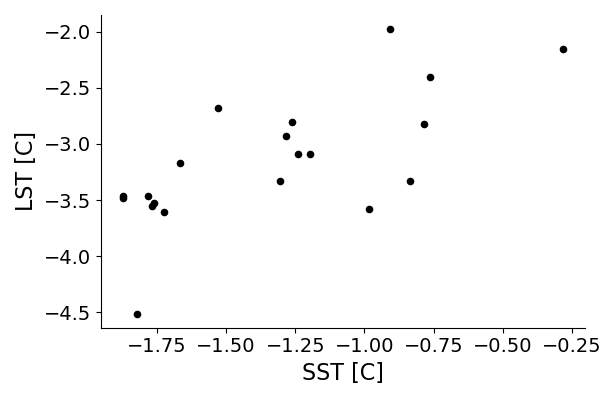

In [15]:
# Plot data points
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 4))

data = lsat_mod_df

a1 = ax
a1.tick_params(labelsize=14)
a1.scatter(data['SST'],data['LST'],color='k',marker='o',s=20,label='_no legend_')

a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
# a1.set_ylim([-2,0.0])
# a1.set_xlim([-3,2.5])
# a1.set_xticks([pd.to_datetime('2022-11'),pd.to_datetime('2022-12'),pd.to_datetime('2023-01'),pd.to_datetime('2023-02')], [pd.to_datetime('2022-11').strftime('%Y-%m'),pd.to_datetime('2022-12').strftime('%Y-%m'),pd.to_datetime('2023-01').strftime('%Y-%m'),pd.to_datetime('2023-02').strftime('%Y-%m')], rotation=45)
a1.set_xlabel('SST [C]',fontsize=16)
a1.set_ylabel('LST [C]',fontsize=16)

plt.tight_layout()
# plt.savefig(figpath / 'SSTvLST.jpg', format='jpg', dpi=400)
plt.show()

## Run SST and LST separate (keep for timeseries work below)

### Run SST data

In [10]:
# Get Landsat file paths in directory
surf_temp = 'LST'

if surf_temp=='SST':
    lpath = sstpath
    lsatfiles = os.listdir(lpath)
    lsatfiles = [x for x in lsatfiles if x[-3:] == 'tif']
    cel = 0
    dtformat = '%Y%m%d%H%M%S'
    calib_m = sstcalib_m
    calib_b = sstcalib_b
    
elif surf_temp=='LST':
    lpath = lstpath
    lsatfiles = os.listdir(lpath)
    lsatfiles = [x for x in lsatfiles if x[-3:] == 'TIF']
    cel = 273.15
    dtformat = '%Y%m%d'
    calib_m = lstcalib_m
    calib_b = lstcalib_b

lsatfiles.sort()
print (len(lsatfiles))

os.chdir(lpath)

57


In [32]:
%%time
# ~ sec per image
# If number of MODIS images per satellite is much more than 25, there is a ULY,LRY issue

sst = []

for i in range(len(lsatfiles)):
    try:
        # Concatenate all landsat files into xarray with a time dimension
        ls_scene = xr.open_dataset(lsatfiles[i],chunks=dict(x=512, y=512),engine='rasterio')['band_data'].sel(band=1)
        ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
    
        if surf_temp == 'SST':
            times = pd.to_datetime(lsatfiles[i][17:25]+lsatfiles[i][41:47], format='%Y%m%d%H%M%S')
            ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-8])
            lsatmin = SSTmin
        elif surf_temp == 'LST':
            times = pd.to_datetime(lsatfiles[i][17:25]+'120000', format='%Y%m%d%H%M%S')
            ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-4])
            lsatmin = LSTmin
    
        # Subset scene and check that it has the correct dimensions because y order changes sometimes
        ls_scene = subset_img(ls_scene,polarx,polary) # subset so easier to work with
        ls_scene = crop_xarray_dataarray_with_polygon(ls_scene, polygon) # crop data to exact bounding box
    
        ts = ls_scene.time.values
        lsID = ls_scene.ID.values
        print (lsID)
        print(ts)
    except Exception as e:
        print (lsID, e)
        continue

    try:
        # Convert to Celsius if needed (LST)
        ls_scene = ls_scene - cel
        
        # # Cross-calibrate to get absolute temps if needed
        ls_sub = ls_scene * calib_m + calib_b
        # ls_sub = ls_scene

        # QA - remove any pixels cooler than 1.9 in landsat (2.0) because likely ice or cloud contaminated
        ls_sub = ls_sub.where(ls_sub >= lsatmin,np.nan)

        # Take mean and count number of pixels used in the calculation
        lsat = np.nanmean(ls_sub)
        pix = ls_sub.notnull().sum().values
    except Exception as e:
        print (lsID, e)
        lsat = np.nan

    # Append file names with each images ID, SST mean, datetime, and pixel count
    sst.append([lsID,ts,lsat,pix])
    print(lsat)

    try:
        del ls_scene, ls_sub
    except:
        pass
     
    gc.collect()

L8 x and y shapes are 0
(0, 0)
LC08_L1GT_166131_20221126_20221206_02_T2_075920 cannot call `vectorize` on size 0 inputs unless `otypes` is set
L8 x and y shapes are 0
(0, 0)
LC08_L1GT_166131_20221126_20221206_02_T2_075920 cannot call `vectorize` on size 0 inputs unless `otypes` is set
L8 x and y shapes are 0
(0, 0)
LC08_L1GT_166131_20221126_20221206_02_T2_075920 cannot call `vectorize` on size 0 inputs unless `otypes` is set
L8 x and y shapes are 0
(0, 0)
LC08_L1GT_166131_20221126_20221206_02_T2_075920 cannot call `vectorize` on size 0 inputs unless `otypes` is set
(437, 436)
LC08_L1GT_007113_20220201_20220211_02_T2_SW_LST
2022-02-01T12:00:00.000000000
-1.3873703
(437, 436)
LC08_L1GT_007113_20220321_20220329_02_T2_SW_LST
2022-03-21T12:00:00.000000000
-2.831326
(437, 436)
LC08_L1GT_007113_20220929_20221004_02_T2_SW_LST
2022-09-29T12:00:00.000000000
-1.9918965
(437, 436)
LC08_L1GT_007113_20221116_20221128_02_T2_SW_LST
2022-11-16T12:00:00.000000000
-1.8632122
(437, 436)
LC08_L1GT_007113_2

In [ ]:
# %%time
# # ~ sec per image
# # If number of MODIS images per satellite is much more than 25, there is a ULY,LRY issue

# sst = []

# for r in range(0,len(lsatfiles),10):
#     # Concatenate all landsat files into xarray with a time dimension
#     try:
#         ls_scenes = xr.open_mfdataset(lsatfiles[r:r+10],chunks=dict(x=512, y=512),combine='nested',preprocess=preprocess,concat_dim="time",engine='rasterio')
#     except:
#         print('end')
#         ls_scenes = xr.open_mfdataset(lsatfiles[r:],chunks=dict(x=512, y=512),combine='nested',preprocess=preprocess,concat_dim="time",engine='rasterio')
    
#     ls_scenes = ls_scenes.rio.write_crs("epsg:3031", inplace=True)
    
#     # Subset all scenes
#     ls_scenes_sub = subset_img(ls_scenes['band_data'].sel(band=1),polarx,polary)

#     # For each processed Landsat SST image in this region
#     for timeidx in range(ls_scenes_sub.time.shape[0]):

#         # Open into xarray and assign proper datetime
#         ls_scene = ls_scenes_sub.isel(time=timeidx)
#         ts = ls_scene.time.values
#         lsID = ls_scene.ID.values
#         print (lsID)
#         print(ts)

#         try:
#             # Cross-calibrate to get absolute temps if needed
#             ls_sub = ls_scene #* calib_m + calib_b

#             # QA - remove any pixels cooler than 1.9 because likely ice or cloud contaminated
#             ls_sub = ls_sub.where(ls_sub>-1.9,np.nan)

#             # Take mean and count number of pixels used in the calculation
#             lsat = np.nanmean(ls_sub)
#             pix = ls_sub.notnull().sum().values
#         except Exception as e:
#             print (lsID, e)
#             lsat = np.nan

#         # Append file names with each images ID, SST mean, datetime, and pixel count
#         sst.append([lsID,ts,lsat,pix])
#         print(lsat)

#         try:
#             del ls_scene, ls_sub
#         except:
#             pass
#         gc.collect()
        
#     try:
#         del ls_scenes, ls_scenes_sub
#     except:
#         pass
#     gc.collect()

In [33]:
# Put data into DataFrame and save    
headers = ['L8_filename','DateTime',f'L8_{surf_temp}','L8_pix']
lsat_mod_df = pd.DataFrame(sst,columns=headers)
# lsat_mod_df = lsat_mod_df.set_index('DateTime')
out_df = basepath / f'Data/DotsonPlume_{surf_temp}_thresh_20240114'
lsat_mod_df.to_pickle(out_df)
lsat_mod_df.head()

,L8_filename,DateTime,L8_LST,L8_pix
0,LC08_L1GT_007113_20220201_20220211_02_T2_SW_LST,2022-02-01 12:00:00,-1.387370,6134
1,LC08_L1GT_007113_20220321_20220329_02_T2_SW_LST,2022-03-21 12:00:00,-2.831326,2701
2,LC08_L1GT_007113_20220929_20221004_02_T2_SW_LST,2022-09-29 12:00:00,-1.991897,18526
3,LC08_L1GT_007113_20221116_20221128_02_T2_SW_LST,2022-11-16 12:00:00,-1.863212,12646
4,LC08_L1GT_007113_20221202_20221212_02_T2_SW_LST,2022-12-02 12:00:00,-1.549271,12965


## Plot Dotson Plume timeseries

In [61]:
# Open interpolated data from Dotson
# out_df = basepath / 'Data/DotsonPlume_SST_interp_20231115'
# out_df = basepath / 'Data/DotsonPlume_SST_nointerp_oldcalib_20231115'
# out_df = basepath / f'Data/DotsonPlume_{surf_temp}_20241128'
# out_df = basepath / f'Data/DotsonPlume_{surf_temp}_thresh2.0_20241128' 2.0 threshold and calibr
# out_df = basepath / f'Data/MODISvLandsat_SST_DotsonIntercomp_thresh_20241128'
# sst_df = basepath / 'Data/MODISvLandsat_SST_DotsonIntercomp_20241128'
# lst_df = basepath / 'Data/MODISvLandsat_LST_DotsonIntercomp_20241128'
# sst_df = basepath / 'Data/MODISvLandsat_SST_DotsonIntercomp_thresh_20241128'
# lst_df = basepath / 'Data/MODISvLandsat_LST_DotsonIntercomp_thresh_20241128'
# sst_df = basepath / 'Data/MODISvLandsat_SST_DotsonIntercomp_thresh3.0_20241128'
# sst_df = basepath / f'Data/MODISvLandsat_SST_Cosgrove_20241128'
# lst_df = basepath / f'Data/MODISvLandsat_LST_Cosgrove_20241128'
# out_df = basepath / f'Data/MODISvLandsat_SST_Cosgrove_thresh_20241128' # uses a 2.0 threshold 
sst_df = basepath / f'Data/MODISvLandsat_SST_Dotson_20241128'
lst_df = basepath / f'Data/MODISvLandsat_LST_Dotson_20241128'
# sst_df = basepath / 'Data/MODISvLandsat_SST_Dotson_thresh_20241128' 
# sst_df2 = basepath / 'Data/MODISvLandsat_SST_Dotson_thresh_20241128_2'
# lst_df = basepath / 'Data/MODISvLandsat_LST_Dotson_thresh_20241128'

ldots = pd.read_pickle(lst_df)
dots = pd.read_pickle(sst_df)
# dots2 = pd.read_pickle(sst_df2)
# dots = pd.concat([dots,dots2])

dots = dots.dropna(axis=0)
dots = dots[dots['L8_pix']>400]
dots = dots.sort_index()

# Calibrate if not already done
if 'thresh' not in str(sst_df):
    dots['L8_SST'] = dots['L8_SST'] * sstcalib_m + sstcalib_b
    ldots['L8_LST'] = ldots['L8_LST'] * lstcalib_m + lstcalib_b

# Loop through each row of ldots
for idx_ldots, row_ldots in ldots.iterrows():
    partial_fname = row_ldots['L8_filename'][:40]  # first 40 chars
    # Find all rows in `dots` whose 'L8_filename' contains that partial string
    mask = dots['L8_filename'].str.contains(partial_fname, na=False)
    # Update the 'LST' column for those matching rows
    dots.loc[mask, 'L8_LST'] = row_ldots['L8_LST']

dots['time'] = dots['L8_filename'].apply(lambda x: str(x)[41:47]) # extract time from filename string
dots['time'] = dots['time'].apply(lambda x: f"{x[:2]}:{x[2:4]}:{x[4:]}")
dots.index = dots.DateTime + pd.to_timedelta(dots['time'])
dots = dots.sort_index()

# Remove the non-numeric column for calculating daily means
numeric_dots = dots.select_dtypes(include=[np.number])
dotmn = numeric_dots.groupby(numeric_dots.index.date).mean()
dots = dots.reset_index()

# Group by the date component of the datetime and calculate the difference
dots['time_dif'] = dots.groupby(dots['index'].dt.date)['index'].diff()
dotmn['time_dif'] = dots.groupby(dots['index'].dt.date)['time_dif'].first()
dotmn['time_hr'] = dotmn['time_dif'].dt.total_seconds()/(60.0*60)
dots['temp_dif'] = dots.groupby(dots['index'].dt.date)['L8_SST'].diff()
dotmn['temp_dif'] = dots.groupby(dots['index'].dt.date)['temp_dif'].first()
dots = dots.set_index('index')

dotmn['std'] = dots.groupby([dots.index.date])['L8_SST'].std()
dotmn['L8_pix'] = dots.groupby([dots.index.date])['L8_pix'].mean()
dotmn['xaxis'] = pd.to_datetime(dotmn.index).dayofyear
dotmn['xaxis'][dotmn['xaxis']<(365/2)] = dotmn['xaxis'] + 365

dots['xaxis'] = pd.to_datetime(dots.index).dayofyear
dots['xaxis'][dots['xaxis']<(365/2)] = dots['xaxis'] + 365

dotmn.tail(4)

,MODIS_SST,MODIS_pix,L8_SST,L8_pix,time_dif,L8_LST,time_hr,temp_dif,std,xaxis
2023-02-10,-1.066656,53566.0,-3.715454,53566.0,NaT,NaN,NaN,NaN,NaN,406
2023-02-19,-1.504550,245077.0,-4.645206,245077.0,0 days 00:00:48,-1.387348,0.013333,-1.373935,0.971519,415
2023-03-09,-1.861716,7546.0,-1.807929,7546.0,0 days 00:00:48,NaN,0.013333,-0.048532,0.034317,433
2023-03-12,-1.819616,17697.0,-1.858243,17697.0,NaT,NaN,NaN,NaN,NaN,436


In [62]:
dotmn[['MODIS_SST','L8_SST','L8_pix','time_dif','time_hr','temp_dif','std','xaxis']]

,MODIS_SST,L8_SST,L8_pix,time_dif,time_hr,temp_dif,std,xaxis
2021-09-27,-1.671126,-1.862960,145057.5,0 days 00:00:48,0.013333,0.041826,0.029575,270
2021-11-21,-1.710151,-3.571726,967204.5,0 days 00:00:48,0.013333,0.011250,0.007955,325
2021-11-30,-1.793229,-5.055843,24193.5,0 days 00:00:48,0.013333,0.027706,0.019591,334
2021-12-03,-1.342619,-1.188128,564604.0,NaT,NaN,NaN,NaN,337
2021-12-05,-1.568987,-1.725746,1125572.0,NaT,NaN,NaN,NaN,339
2021-12-13,-1.488041,-1.515513,24609.0,NaT,NaN,NaN,NaN,347
2021-12-16,-1.220613,-0.725157,454628.0,NaT,NaN,NaN,NaN,350
2021-12-20,-1.095948,-0.906082,15840.0,NaT,NaN,NaN,NaN,354
2021-12-21,-0.930949,-0.719906,2292493.0,NaT,NaN,NaN,NaN,355
2021-12-23,-0.847790,-0.329209,1808716.0,0 days 00:00:48,0.013333,0.028174,0.019922,357


In [63]:
# # Open not interpolated data from Dotson
# out_df = basepath / 'Data/DotsonPlume_SST_nointerp_20231115'
# out_df = basepath / 'Data/DotsonPlume_SST_oldfunction_nointerp_oldcalib_20231115'
# dots = pd.read_pickle(out_df)

# dots = dots.dropna(axis=0)
# dots = dots[dots['count']>400]
# dots = dots.sort_index()
# dots['time'] = dots['L8_filename'].apply(lambda x: str(x)[41:47]) # extract time from filename string
# dots['time'] = dots['time'].apply(lambda x: f"{x[:2]}:{x[2:4]}:{x[4:]}")
# dots.index = dots.index + pd.to_timedelta(dots['time'])
# dots = dots.sort_index()

# dotmnNI = dots.groupby([dots.index.date]).mean()
# dots = dots.reset_index()

# # Group by the date component of the datetime and calculate the difference
# dots['time_dif'] = dots.groupby(dots['index'].dt.date)['index'].diff()
# dotmnNI['time_dif'] = dots.groupby(dots['index'].dt.date)['time_dif'].first()
# dotmnNI['time_hr'] = dotmnNI['time_dif'].dt.total_seconds()/(60.0*60)
# dots['temp_dif'] = dots.groupby(dots['index'].dt.date)['L8_SST'].diff()
# dotmnNI['temp_dif'] = dots.groupby(dots['index'].dt.date)['temp_dif'].first()
# dots = dots.set_index('index')

# dotmnNI['std'] = dots.groupby([dots.index.date])['L8_SST'].std()
# dotmnNI['xaxis'] = pd.to_datetime(dotmnNI.index).dayofyear
# dotmnNI['xaxis'][dotmnNI['xaxis']<(365/2)] = dotmnNI['xaxis'] + 365

# dots['xaxis'] = pd.to_datetime(dots.index).dayofyear
# dots['xaxis'][dots['xaxis']<(365/2)] = dots['xaxis'] + 365

# data = dotmnNI

# d2022NI = data[pd.to_datetime('2022-09'):pd.to_datetime('2023-04')]
# d2021NI = data[pd.to_datetime('2021-09'):pd.to_datetime('2022-04')]
# d2020NI = data[pd.to_datetime('2020-09'):pd.to_datetime('2021-04')]
# d2019NI = data[pd.to_datetime('2019-09'):pd.to_datetime('2020-04')]
# d2018NI = data[pd.to_datetime('2018-09'):pd.to_datetime('2019-04')]

# dotmnNI.head(4)

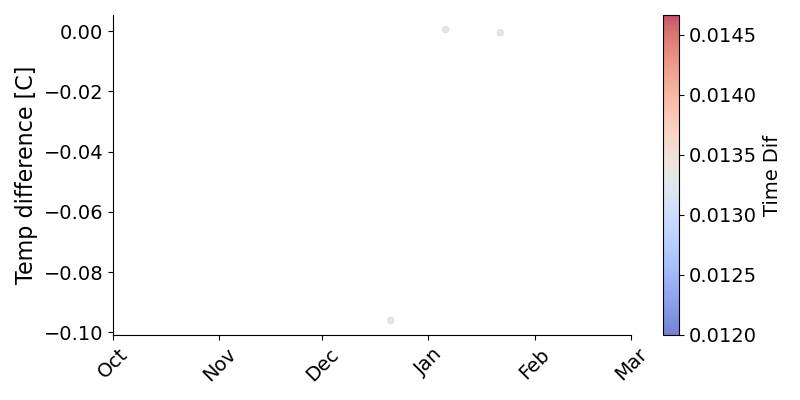

In [15]:
# Plot data points
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(8, 4))

data = dotmn

a1 = ax
a1.tick_params(labelsize=14)
cb = a1.scatter(data['xaxis'],data['temp_dif'],c=data['time_hr'],cmap='coolwarm',marker='o',s=20,alpha=0.7) #

a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
# a1.set_ylim([-2.1,0])
# a1.set_xlim([-3,2.5])
a1.set_xticks([pd.to_datetime('2022-10').dayofyear,pd.to_datetime('2022-11').dayofyear,pd.to_datetime('2022-12').dayofyear,pd.to_datetime('2023-01').dayofyear+365,pd.to_datetime('2023-02').dayofyear+365,pd.to_datetime('2023-03').dayofyear+365], ['Oct','Nov','Dec','Jan','Feb','Mar'], rotation=45)
a1.set_ylabel('Temp difference [C]',fontsize=16)
# a1.legend(markerscale=1,fontsize=12,loc='upper left')
cbar = plt.colorbar(cb, label='Time Dif')
cbar.ax.set_ylabel('Time Dif', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
# plt.savefig(figpath / 'DotsonReplicates.jpg', format='jpg', dpi=400)
plt.show()

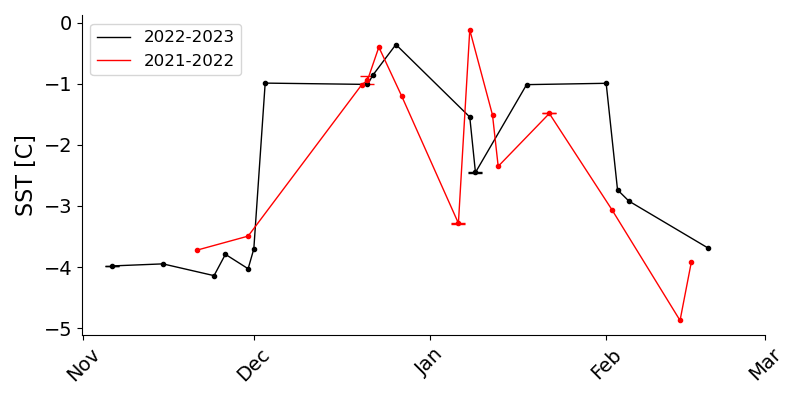

In [45]:
# Plot data points
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(8, 4))

data = dotmn
col = 'L8_SST'

# Ensure the DataFrame index is in DatetimeIndex format
data.index = pd.to_datetime(data.index)

d2022 = data.loc[pd.to_datetime('2022-09'):pd.to_datetime('2023-04')]
d2021 = data.loc[pd.to_datetime('2021-09'):pd.to_datetime('2022-04')]
# d2020 = data[pd.to_datetime('2020-09'):pd.to_datetime('2021-04')]
# d2019 = data[pd.to_datetime('2019-09'):pd.to_datetime('2020-04')]
# d2018 = data[pd.to_datetime('2018-09'):pd.to_datetime('2019-04')]

a1 = ax
a1.tick_params(labelsize=14)
a1.errorbar(d2022['xaxis'],d2022[col],yerr=d2022['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
a1.plot(d2022['xaxis'],d2022[col],color='k',ls='-',linewidth=1,label='2022-2023')
a1.errorbar(d2021['xaxis'],d2021[col],yerr=d2021['std'],color='r',fmt='o',ecolor='r',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
a1.plot(d2021['xaxis'],d2021[col],color='r',ls='-',linewidth=1,label='2021-2022')
# a1.errorbar(d2020['xaxis'],d2020[col],yerr=d2020['std'],color='0.6',fmt='o',ecolor='0.6',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# a1.plot(d2020['xaxis'],d2020[col],color='0.6',ls='-',linewidth=1,label='2020-2021')
# a1.errorbar(d2019['xaxis'],d2019[col],yerr=d2019['std'],color='C7',fmt='o',ecolor='C7',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# a1.plot(d2019['xaxis'],d2019[col],color='C7',ls='-',linewidth=1,label='2019-2020')
# a1.errorbar(d2018['xaxis'],d2018[col],yerr=d2018['std'],color='C4',fmt='o',ecolor='C4',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# a1.plot(d2018['xaxis'],d2018[col],color='C4',ls='-',linewidth=1,label='2018-2019')

a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
# a1.set_ylim([-2.1,0.6])
# a1.set_xlim([-3,2.5])
a1.set_xticks([pd.to_datetime('2022-11').dayofyear,pd.to_datetime('2022-12').dayofyear,pd.to_datetime('2023-01').dayofyear+365,pd.to_datetime('2023-02').dayofyear+365,pd.to_datetime('2023-03').dayofyear+365], ['Nov','Dec','Jan','Feb','Mar'], rotation=45)
# a1.set_xticks([pd.to_datetime('2022-10').dayofyear,pd.to_datetime('2022-11').dayofyear,pd.to_datetime('2022-12').dayofyear,pd.to_datetime('2023-01').dayofyear+365,pd.to_datetime('2023-02').dayofyear+365,pd.to_datetime('2023-03').dayofyear+365], ['Oct','Nov','Dec','Jan','Feb','Mar'], rotation=45)
# a1.set_xlabel('Day of Year',fontsize=16)
a1.set_ylabel('SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig(figpath / 'DotsonSSTseasonal.jpg', format='jpg', dpi=400)
plt.show()

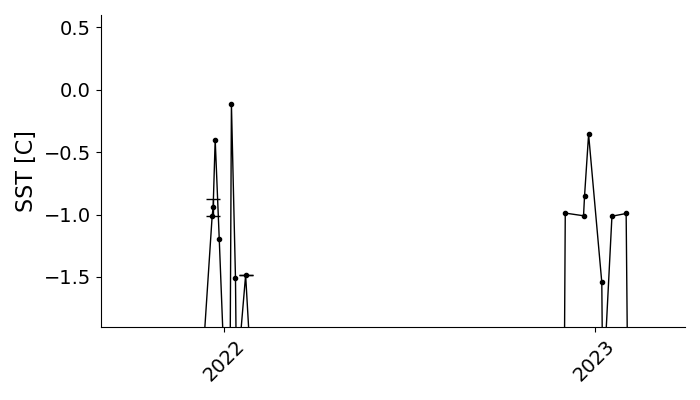

In [46]:
# Plot data points
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(7, 4))

data = dotmn

a1 = ax
a1.tick_params(labelsize=14)
# a1.errorbar(data.index,data['L8_SST'],yerr=data['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
a1.scatter(data.index,data['L8_SST'],color='k',marker='o',s=3,label='_no legend_')

a1.plot(d2022.index,d2022['L8_SST'],color='k',ls='-',linewidth=1,label='2022-2023')
a1.errorbar(d2022.index,d2022['L8_SST'],yerr=d2022['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
a1.plot(d2021.index,d2021['L8_SST'],color='k',ls='-',linewidth=1,label='2021-2022')
a1.errorbar(d2021.index,d2021['L8_SST'],yerr=d2021['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# a1.plot(d2020.index,d2020['L8_SST'],color='k',ls='-',linewidth=1,label='2020-2021')
# a1.plot(d2019.index,d2019['L8_SST'],color='k',ls='-',linewidth=1,label='2019-2020')
# a1.plot(d2018.index,d2018['L8_SST'],color='k',ls='-',linewidth=1,label='2018-2019')

a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
a1.set_ylim([-1.9,0.6])
a1.set_xticks([pd.to_datetime('2022'),pd.to_datetime('2023')], ['2022','2023'], rotation=45)
# a1.set_xticks([pd.to_datetime('2018'),pd.to_datetime('2019'),pd.to_datetime('2020'),pd.to_datetime('2021'),pd.to_datetime('2022'),pd.to_datetime('2023')], ['2018','2019','2020','2021','2022','2023'], rotation=45)
a1.set_xlim([pd.to_datetime('2021-09-01'),pd.to_datetime('2023-03-31')])
# a1.set_xlabel('Day of Year',fontsize=16)
a1.set_ylabel('SST [C]',fontsize=16)
# a1.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig(figpath / 'DotsonSSTtimeseries.jpg', format='jpg', dpi=400)
plt.show()

In [21]:
# # Plot interpolated vs not interpolated (remove)
# fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(7, 4))

# data = dotmn

# a1 = ax
# a1.tick_params(labelsize=14)

# a1.plot(d2022NI.index,d2022NI['L8_SST'],color='r',ls='-',linewidth=1,label='No Interp, Old function')
# a1.errorbar(d2022NI.index,d2022NI['L8_SST'],yerr=d2022NI['std'],color='r',fmt='o',ecolor='r',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# a1.plot(d2021NI.index,d2021NI['L8_SST'],color='r',ls='-',linewidth=1,label='_no legend_')
# a1.errorbar(d2021NI.index,d2021NI['L8_SST'],yerr=d2021NI['std'],color='r',fmt='o',ecolor='r',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')

# a1.plot(d2022.index,d2022['L8_SST'],color='k',ls='-',linewidth=1,label='No Interp, Old Calibration')
# a1.errorbar(d2022.index,d2022['L8_SST'],yerr=d2022['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# a1.plot(d2021.index,d2021['L8_SST'],color='k',ls='-',linewidth=1,label='_no legend_')
# a1.errorbar(d2021.index,d2021['L8_SST'],yerr=d2021['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')

# a1.spines['top'].set_visible(False)
# a1.spines['right'].set_visible(False)
# a1.set_ylim([-1.9,0.6])
# a1.set_xticks([pd.to_datetime('2022'),pd.to_datetime('2023')], ['2022','2023'], rotation=45)
# # a1.set_xticks([pd.to_datetime('2018'),pd.to_datetime('2019'),pd.to_datetime('2020'),pd.to_datetime('2021'),pd.to_datetime('2022'),pd.to_datetime('2023')], ['2018','2019','2020','2021','2022','2023'], rotation=45)
# a1.set_xlim([pd.to_datetime('2021-09-01'),pd.to_datetime('2023-03-31')])
# # a1.set_xlabel('Day of Year',fontsize=16)
# a1.set_ylabel('SST [C]',fontsize=16)
# a1.legend(markerscale=1,fontsize=12,loc='upper center')

# plt.tight_layout()
# # plt.savefig(figpath / 'DotsonSSTtimeseries.jpg', format='jpg', dpi=400)
# plt.show()

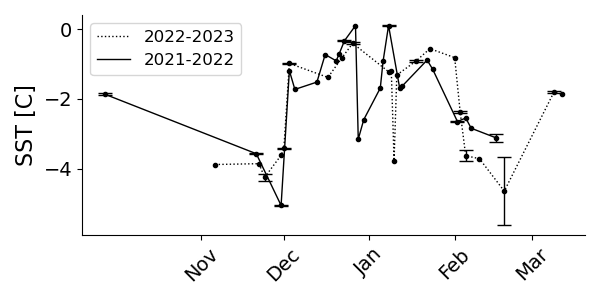

In [64]:
# Plot MODIS vs Landsat SST on calibration runs 
# Something is weird with Landsat observations in Nov, Dec, and Feb
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 3))

data = dotmn
col = 'L8_SST'

# Ensure the DataFrame index is in DatetimeIndex format
data.index = pd.to_datetime(data.index)

d2022 = data.loc[pd.to_datetime('2022-09'):pd.to_datetime('2023-04')]
d2021 = data.loc[pd.to_datetime('2021-09'):pd.to_datetime('2022-04')]

a1 = ax
a1.tick_params(labelsize=14)

# MODIS
# a1.errorbar(d2022['xaxis'],d2022[col],yerr=d2022['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# a1.plot(d2022['xaxis'],d2022[col],color='k',ls='-',linewidth=1,label='2022-2023')
# a1.errorbar(d2021['xaxis'],d2021[col],yerr=d2021['std'],color='r',fmt='o',ecolor='r',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# a1.plot(d2021['xaxis'],d2021[col],color='r',ls='-',linewidth=1,label='2021-2022')
# a1.errorbar(d2020['xaxis'],d2020[col],yerr=d2020['std'],color='0.6',fmt='o',ecolor='0.6',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# a1.plot(d2020['xaxis'],d2020[col],color='0.6',ls='-',linewidth=1,label='2020-2021')

# Landsat
a1.errorbar(d2022['xaxis'],d2022[col],yerr=d2022['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
a1.plot(d2022['xaxis'],d2022[col],color='k',ls=':',linewidth=1,label='2022-2023')
a1.errorbar(d2021['xaxis'],d2021[col],yerr=d2021['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
a1.plot(d2021['xaxis'],d2021[col],color='k',ls='-',linewidth=1,label='2021-2022')

a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
# a1.set_ylim([-2.1,0.6])
# a1.set_xlim([-3,2.5])
a1.set_xticks([pd.to_datetime('2022-11').dayofyear,pd.to_datetime('2022-12').dayofyear,pd.to_datetime('2023-01').dayofyear+365,pd.to_datetime('2023-02').dayofyear+365,pd.to_datetime('2023-03').dayofyear+365], ['Nov','Dec','Jan','Feb','Mar'], rotation=45)
# a1.set_xticks([pd.to_datetime('2022-10').dayofyear,pd.to_datetime('2022-11').dayofyear,pd.to_datetime('2022-12').dayofyear,pd.to_datetime('2023-01').dayofyear+365,pd.to_datetime('2023-02').dayofyear+365,pd.to_datetime('2023-03').dayofyear+365], ['Oct','Nov','Dec','Jan','Feb','Mar'], rotation=45)
# a1.set_xlabel('Day of Year',fontsize=16)
a1.set_ylabel('SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig(figpath / 'DotsonSSTseasonal.jpg', format='jpg', dpi=400)
plt.show()

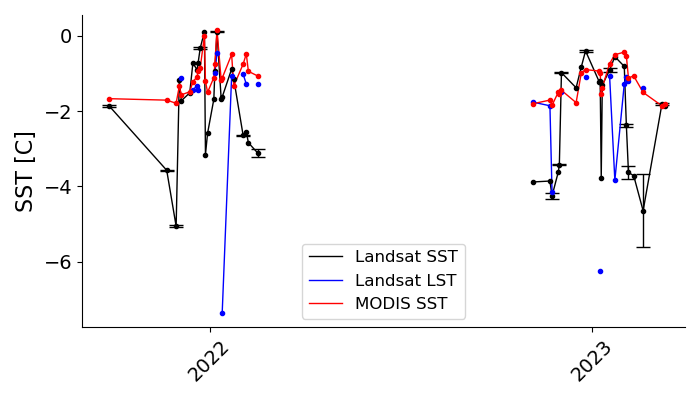

In [65]:
# Plot MODIS vs Landsat SST 
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(7, 4))

a1 = ax
a1.tick_params(labelsize=14)

col = 'L8_SST'
color = 'k'
a1.plot(d2022.index,d2022[col],color=color,ls='-',linewidth=1,label='Landsat SST')
a1.errorbar(d2022.index,d2022[col],yerr=d2022['std'],color=color,fmt='o',ecolor=color,elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
a1.plot(d2021.index,d2021[col],color=color,ls='-',linewidth=1,label='_no legend_')
a1.errorbar(d2021.index,d2021[col],yerr=d2021['std'],color=color,fmt='o',ecolor=color,elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')

col = 'L8_LST'
color = 'b'
a1.plot(d2022.index,d2022[col],color=color,ls='-',linewidth=1,label='Landsat LST')
a1.errorbar(d2022.index,d2022[col],yerr=d2022['std'],color=color,fmt='o',ecolor=color,elinewidth=0,capthick=0,marker='o',ms=3,capsize=0,label='_no legend_')
a1.plot(d2021.index,d2021[col],color=color,ls='-',linewidth=1,label='_no legend_')
a1.errorbar(d2021.index,d2021[col],yerr=d2021['std'],color=color,fmt='o',ecolor=color,elinewidth=0,capthick=0,marker='o',ms=3,capsize=0,label='_no legend_')

col = 'MODIS_SST'
color = 'r'
a1.plot(d2022.index,d2022[col],color=color,ls='-',linewidth=1,label='MODIS SST')
a1.errorbar(d2022.index,d2022[col],yerr=d2022['std'],color=color,fmt='o',ecolor=color,elinewidth=0,capthick=0,marker='o',ms=3,capsize=0,label='_no legend_')
a1.plot(d2021.index,d2021[col],color=color,ls='-',linewidth=1,label='_no legend_')
a1.errorbar(d2021.index,d2021[col],yerr=d2021['std'],color=color,fmt='o',ecolor=color,elinewidth=0,capthick=0,marker='o',ms=3,capsize=0,label='_no legend_')

a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
# a1.set_ylim([-1.9,0.6])
a1.set_xticks([pd.to_datetime('2022'),pd.to_datetime('2023')], ['2022','2023'], rotation=45)
# a1.set_xticks([pd.to_datetime('2018'),pd.to_datetime('2019'),pd.to_datetime('2020'),pd.to_datetime('2021'),pd.to_datetime('2022'),pd.to_datetime('2023')], ['2018','2019','2020','2021','2022','2023'], rotation=45)
a1.set_xlim([pd.to_datetime('2021-09-01'),pd.to_datetime('2023-03-31')])
# a1.set_xlim([pd.to_datetime('2022-11-01'),pd.to_datetime('2023-02-28')])
# a1.set_xlabel('Day of Year',fontsize=16)
a1.set_ylabel('SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=12,loc='lower center')

plt.tight_layout()
# plt.savefig(figpath / 'DotsonSSTtimeseries.jpg', format='jpg', dpi=400)
plt.show()

In [60]:
dotmn

,MODIS_SST,MODIS_pix,L8_SST,L8_pix,time_dif,L8_LST,time_hr,temp_dif,std,xaxis
2021-09-27,-1.671126,145057.5,-1.862960,145057.5,0 days 00:00:48,NaN,0.013333,0.041826,0.029575,270
2021-11-21,-1.710151,967204.5,-3.571726,967204.5,0 days 00:00:48,NaN,0.013333,0.011250,0.007955,325
2021-11-30,-1.793229,24193.5,-5.055843,24193.5,0 days 00:00:48,NaN,0.013333,0.027706,0.019591,334
2021-12-03,-1.342619,564604.0,-1.188128,564604.0,NaT,NaN,NaN,NaN,NaN,337
2021-12-05,-1.568987,1125572.0,-1.725746,1125572.0,NaT,-1.121859,NaN,NaN,NaN,339
2021-12-13,-1.488041,24609.0,-1.515513,24609.0,NaT,NaN,NaN,NaN,NaN,347
2021-12-16,-1.220613,454628.0,-0.725157,454628.0,NaT,-1.437478,NaN,NaN,NaN,350
2021-12-20,-1.095948,15840.0,-0.906082,15840.0,NaT,-1.327333,NaN,NaN,NaN,354
2021-12-21,-0.930949,2292493.0,-0.719906,2292493.0,NaT,-1.429358,NaN,NaN,NaN,355
2021-12-23,-0.847790,1808716.0,-0.329209,1808716.0,0 days 00:00:48,NaN,0.013333,0.028174,0.019922,357


## Check matchups

In [59]:
from matplotlib.patches import Polygon as Pgon

import pandas as pd
import xarray as xr
import geopandas as gpd
from datetime import date, timedelta, datetime
import numpy as np
import matplotlib.pylab as plt
from matplotlib import colors
from matplotlib.pylab import rcParams
from matplotlib.patches import Polygon as Pgon
import cartopy.crs as ccrs
import cartopy

import os
from cycler import cycler
import pyproj
from pyproj import Proj, transform
from sklearn.neighbors import BallTree
import pytz
import pygmt
import gc
import copy
import random
import statsmodels.formula.api as sm
import scipy.stats as stats
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
# from shapely.geometry.polygon import Polygon
from shapely.geometry import Point, Polygon
from pathlib import Path
import math
from scipy.odr import Model, RealData, ODR
from tqdm.notebook import trange, tqdm

import earthaccess


In [57]:
basepath = Path('/home/jovyan/Landsat_SST_algorithm')
spacing = [990,-990] # 990m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
param = 'sea_surface_temperature'
size_threshold = 30

In [53]:
##########################

def crosses_idl(coords):
    '''
    Determine if the set of coordinates crosses the International Dateline in a way that will mess up the creation of a polygon
    
    Variables:
    coords = list of lon, lat tuples
    
    Output:
    True or False
    '''
    
    for (lon1, lat1), (lon2, lat2) in zip(coords, coords[1:]):
        if abs(lon1 - lon2) >= 180:
            return True
    return False


In [51]:
def find_MODIS(lonboundsC,latboundsC,ls_scene):
    '''
    Finds the MODIS scene most closely coincident to a Landsat scene
    Uses full Landsat scene extent, not cropped
    
    Variables: 
    ls_scene = xarray for one Landsat scene
    
    Outputs:
    mod_scene = xarray of MODIS SST image coincident in time with the Landsat scene
    granules[ind]['umm']['GranuleUR'] = modis file name
    min_time = the time difference between the Landsat image acquisition and chosen MODIS image
    
    **not done, Differences from NLSST: 0.0 used as percent_dif requiring 100% overlap between MODIS and Landsat here since the subset area is so small
    '''
    
    mbox = (lonboundsC[0],latboundsC[0],lonboundsC[1],latboundsC[1]) #east, south,west,north

    # Construct a polygon to select a best fit MODIS image based on overlap
    # Using the entire Landsat image
    ls_scene_reproj = ls_scene.rio.reproject("EPSG:4326")
    xmin,xmax,ymin,ymax = ls_scene_reproj.x.values[0],ls_scene_reproj.x.values[-1],ls_scene_reproj.y.values[0],ls_scene_reproj.y.values[-1]
    lsatpoly = Polygon([(xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin),(xmin,ymin)])
    # # (Not using) Using only the sampling box
    # # (Note) This produces artifacts in MODIS_lookup because the Landsat grid will be an extrapolation outside the MODIS grid and streaking occurs
    # lsatpoly = Polygon([(lonboundsC[0],latboundsC[1]),(lonboundsC[0],latboundsC[0]),(lonboundsC[1],latboundsC[0]),(lonboundsC[1],latboundsC[1]),(lonboundsC[0],latboundsC[1])])
    
    # Get date/time for Landsat image and search for corresponding MODIS imagery  
    ls_time = pd.to_datetime(ls_scene.time.values)
    calc_dt = datetime.strptime(ls_time.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
    start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
    end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')
    
    # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
    granules = earthaccess.search_data(
        short_name='MODIS_T-JPL-L2P-v2019.0',
        bounding_box=mbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules2 = earthaccess.search_data(
        short_name='MODIS_A-JPL-L2P-v2019.0', #MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_NIGHTTIME_V2019.0
        bounding_box=mbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules = granules + granules2
    print (f'{len(granules)} TOTAL MODIS granules')

    # Accept only MODIS granules that overlap at least a perscribed amount with Landsat, in this case 100% => percent_dif=0.0
    best_grans = []
    for granule in granules:
        try:
            granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
        except Exception as error:
            print(error)
            continue
            # Would love to raise an exception for a valueerror except for GEOSError
        for num in range(len(granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'])):
            try:
                # Extract points, make into a polygon
                map_points = [(xi['Longitude'],xi['Latitude']) for xi in granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][num]['Boundary']['Points']]
                pgon = Polygon(map_points)
                percent_dif = lsatpoly.difference(pgon).area/lsatpoly.area
                # If the polygon covers the landsat area, check to make sure it doesn't cross the international date line with a messed up polygon (these are searched wrong in earthaccess so probably need adjustment there)
                if percent_dif == 0.0:
                    if crosses_idl(map_points):
                        print (f'A granule has messed up polygon that likely crosses the International DateLine')
                    else:
                        best_grans.append(granule)
                        continue
            except Exception as error:
                print(error)
                # Would love to raise an exception for a valueerror except for GEOSError
    print(f'{len(best_grans)} remaining MODIS granules')

    # Find MODIS image closest in time to each Landsat image
    # Make Landsat datetime timezone aware (UTC)
    Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in best_grans]
    ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(ls_time))))
    time_dif = abs(Mdates[ind] - pytz.utc.localize(pd.to_datetime(ls_time)))
    print(f'Time difference between MODIS and Landsat: {time_dif}')

    mod_scene = xr.open_dataset(earthaccess.open(best_grans[ind:ind+1])[0])
    mod_scene = mod_scene.rio.write_crs("epsg:4326", inplace=True) 
    
    return mod_scene, granules[ind]['umm']['GranuleUR'],time_dif

##########################  

def get_wv(ls_scene,mod07,spacing,param):
    '''
    ***This is copied in LandsatCalibration, modifications have been made but some may tranfer
    
    Create MODIS files aligned and subsampled to Landsat
    
    Variables:
    ls_scene = xarray dataset of a Landsat scene
    mod07 = xarray datarray with MODIS data
    spacing = list of desired spatial resolution of output data from the alignment of MODIS to Landsat in y and x (e.g.,[300,-300])
    param = string for desired dataset from MODIS file
    
    Output:
    WV_xr = xarray dataarray of Landsat aligned and upsampled modis data from desired dataset
    
    Differences from NLSST: scene is not a parameter (used for test_gridcoords), SST gets extracted differently into data/lat/lon
    
    '''
    # Read in desired variables and paths
    
    uniqWV = []

    ULX = ls_scene.x[0] 
    ULY = ls_scene.y[0]
    LRX = ls_scene.x[-1]
    LRY = ls_scene.y[-1] 
    box = [ULX,LRX,ULY,LRY]
    
    #Extract desired datasets from MODIS file
    if param == 'sea_surface_temperature': 
        data = mod07[0,:,:]
        lat, lon = mod07.lat, mod07.lon
    else: 
        data = mod07[param]
        lat, lon = mod07.Latitude, mod07.Longitude    

    # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
    indiciesMOD,lines,samples = MODISlookup(mod07,ls_scene,box,spacing)

    # Align MODIS SST to Landsat on slightly upsampled grid # have the option to output `uniqImgWV` if want to know range of data
    dataOutWV_xr = alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing)

    # Resample MODIS to Landsat resolution and interpolate with B-spline
    # Output of shape fits and need to adjust x and y coords cuz are wrong
    ups_factor = 30/spacing[0]
    WV_upsample = pygmt.grdsample(grid=dataOutWV_xr, spacing=f'{ups_factor}k') # ,interpolation='b' if prefer to interpolate with bspline but don't think it is useful here

    # Put into Xarray
    latnew = ls_scene.y[:WV_upsample.shape[0]].values
    lonnew = ls_scene.x[:WV_upsample.shape[1]].values
    if dataOutWV_xr.latitude[0]!=latnew[0]:
        print('Aligned y dim needs to start with the same coordinate as ls_scene')
    if dataOutWV_xr.longitude[0]!=lonnew[0]:
        print('Aligned x dim needs to start with the same coordinate as ls_scene')
    
    WV_xr = xr.DataArray(WV_upsample,name='SST',dims=["y","x"], coords={"latitude": (["y"],latnew), "longitude": (["x"],lonnew)})
    WV_xr = WV_xr.rio.write_crs("epsg:3031", inplace=True)
    WV_xr = WV_xr.rename({'longitude':'x','latitude':'y'})
    WV_xr = WV_xr.set_index(x='x')
    WV_xr = WV_xr.set_index(y='y')

#     #Append WV values
#     uniqWV.append(uniqImgWV)
    
#     try:
#         # Min and max MODIS values for a scene
#         maxi =[]
#         mini =[]
#         for m in uniqWV:
#             maxi.append(max(m))
#             mini.append(min(m))

#         print (f'Max {param}: {np.max(maxi)}, min: {np.min(mini)}')
#     except:
#         print (f'Max {param}: {np.nan}, min: {np.nan}')
    
    return WV_xr
           
##########################           

def MODISlookup (mod07,ls_scene,box,spacing):
    '''
    Look up atmospheric consituents from MODIS product for each Landsat pixel
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file 
    # and Shane Grigsby

    Variables:    
    mod07 = xarray with MODIS data with crs 4326 assigned
    ls_scene =  Landsat xarray DataArray
    box = list with [left easting,right easting,top northing,bottom northing]
    spacing = desired pixel size for extraction, list of [east/west, north/south] 
          (recommend choosing a number that allows for fast calculations and even division by 30)

    Output:
    indiciesMOD = indicies used to project MODIS pixels to match Landsat pixels
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    x1,y1 = x and y coordinates for grid
    
    Differences from NLSST: lat/lon variables named differently in SST vs WV files, no interpolation,
    test_gridcoords does not use `scene`, don't need to output lat/lon because do not interpolate and make 
    new ones
    
    '''
    test_threshold = 5 
    
    lat, lon = mod07.lat, mod07.lon # Different for SST vs WV
    
    # Test lat is in correct range
    if ~((lat <= 90) & (lat >= -90)).all():
        print('MODIS latitude not between -90 and 90')
    # Test lon is in correct range
    if ~((lon <= 180) & (lon >= -180)).all():
        print('MODIS longitude not between -180 and 180')

    # Get the existing coordinate system
    old_cs = ls_scene.rio.crs # 'epsg:3031'
    new_cs = mod07.rio.crs # 'epsg:4326'

    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)

    # Parse coordinates and spacing to different variables
    west,east,north,south = box
    ewspace,nsspace = spacing

    # Setting up grid, x coord from here to here at this spacing, mesh grid makes 2D
    samples = len(np.r_[west:east+1:ewspace])
    lines = len(np.r_[north:south-1:nsspace])#ns space is -300, could also do 30 instead of 300, but would just have duplicate pixels
    if lines==0:
        lines = len(np.r_[south:north-1:nsspace])
        
    # x1, y1 = np.meshgrid(np.r_[west:east:ewspace],np.r_[north:south:nsspace]) # offset by 1 meter to preserve shape
    ewdnsamp = int(spacing[0]/30)
    nsdnsamp = int(spacing[1]/30)

    # Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
    xresamp = ls_scene.x.isel(x=slice(None, None, ewdnsamp)).values
    if xresamp[0]!=ls_scene.x.values[0]:
        xresamp = ls_scene.x.isel(x=slice(None, None, -ewdnsamp)).values
        
    yresamp = ls_scene.y.isel(y=slice(None, None, nsdnsamp)).values
    if yresamp[0]!=ls_scene.y.values[0]:
        yresamp = ls_scene.y.isel(y=slice(None, None, -nsdnsamp)).values

    x1, y1 = np.meshgrid(xresamp,yresamp)
    LScoords = np.vstack([x1.ravel(),y1.ravel()]).T
    if (LScoords[0,0]!=ls_scene.x.values[0]) |  (LScoords[0,1]!=ls_scene.y.values[0]):
        raise Exception('Landsat coordinates do not match expected during MODIS lookup')

    # Ravel so ND can lookup easily
    # Convert from LS map coords to lat lon --> x = lon, y = lat (usually?)
    # Test that reprojection is working correctly on first and last grid point using round-trip transformation
    xs1, ys1 =  transform(inProj,outProj,LScoords[0,0], LScoords[0,1], radians=True, always_xy=True)
    xsl1, ysl1 =  transform(outProj,inProj,xs1, ys1, radians=True, always_xy=True)
    if np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:]) > test_threshold:
        print(f"Round-trip transformation error for point {LScoords[0,:]}, {np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:])}")
    else:
        # If passes, run on entire grid
        xs, ys =  transform(inProj,outProj,LScoords[:,0], LScoords[:,1], radians=True, always_xy=True)

    # Produce landsat reprojected to lat/lon and ensure lat is in 0 column
    grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T
    # Test that lines and samples match grid_coords
    if len(grid_coords) != lines*samples:
        raise Exception(f'Size of grid coordinates do not match low resolution Landsat dims: {len(grid_coords)} vs. {lines*samples}. Check that spacing is negative for y')
    MODIS_coords = np.vstack([lat.values.ravel(),lon.values.ravel()]).T
    MODIS_coords *= np.pi / 180. # to radians
    
    # Build lookup, haversine = calc dist between lat,lon pairs so can do nearest neighbor on sphere - if did utm it would be planar
    MOD_Ball = BallTree(MODIS_coords,metric='haversine') #sklearn library
    distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)
        
    return indiciesMOD,lines,samples

##########################

def test_gridcoords(xs,ys):
    '''
    Test to ensure grid lat and lon are not swapped during reprojection and output grid coordinates
    that have been raveled and stacked for input into BallTree. There is some uncertainty only when the image is
    taken between -60 and -90 longitude because lat and lon can have the same values.
    
    Variables:
    xs = 1D radians representing longitude 
    ys = 1D radians representing latitude
    
    Output:
    grid_coords = two columns of x/y radian pairs representing lon/lat
    
    Differences from NLSST: elif is different than NLSST pipeline
    '''
    
    # Convert radians to lat/lon
    x_check = xs * 180. / np.pi
    y_check = ys * 180. / np.pi
    
    # We know lat is ys and lon is xs if this is true so goes in 0 column position to match MODIS
    if ((-90 <= y_check) & (y_check <= -60)).all() & ~((-90 <= x_check) & (x_check <= -60)).all():
        grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
        print('Latitude in proper position')

    # A small subset of data have lat and lon that falls between -60 and -90 so test if the landsat metadata confirms that
    elif ((-90 <= y_check) & (y_check <= -60)).all():
        # xs is latitude if not and goes in 0 column position
        grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T 
        print('Latitude in uncertain position, may be incorrect')

    # Otherwise xs is latitude and goes in 0 column position
    else:
        grid_coords = np.vstack([xs.ravel(),ys.ravel()]).T
        print('Latitude in wrong position')
    
    return grid_coords

##########################

def alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing):
    '''
    Align MODIS image to Landsat and resample at indicated spacing
    
    Variables:
    data =
    lat = 
    lon = 
    param =
    indiciesMOD =
    lines = 
    samples =
    mod07 = 
    ls_scene =
    spacing =
    
    Output:
    dataOut_xr = 
    
    Not currently set, but can also output: 
    uniqImg = uniq MODIS atm values within area of Landsat image
    '''
    test_threshold = 5
    
    if (np.shape(lat)== np.shape(lon)== np.shape(data))==False:
            raise Exception("Error in creating indicies, lat/lon and data shapes do not match")
            
    # Extract MODIS data into Landsat grid and gather unique data values
    dataOut,uniqImg = uniqueMODIS(data,param,indiciesMOD,lines,samples)
    
    # Check grid directionality and create matching x/y for new grid
    # Define the source and target coordinate reference systems (CRS)
    src_crs = mod07.rio.crs #'epsg:4326'  MODIS
    target_crs = ls_scene.rio.crs #crs[6:] # 'epsg:3031' Landsat

    # Create a PyProj transformer
    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
    transformer_test = pyproj.Transformer.from_crs(target_crs, src_crs, always_xy=True)

    # Test that reprojection is working correctly on first and last grid point
    xm1,xm2 = lon[0,0],lon[-1,-1]
    ym1,ym2 = lat[0,0],lat[-1,-1]
    xx,yy = [xm1,xm2], [ym1,ym2]
    xs1, ys1 =  transformer.transform(xx,yy)
    xsl1, ysl1 = transformer_test.transform(xs1, ys1)
    for i,n in enumerate(xsl1):
        if np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - [xx[i],yy[i]]) > test_threshold:
            print(f"Round-trip transformation error for {sceneid}, {np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - xx[i],yy[i])}")

    # Spacing to create x and y parameters at the correct spacing
    red_y = int(abs(spacing[0]/30))
    red_x = int(abs(spacing[1]/30))

    # Set up coarser sampling grid to match spacing and check to make sure is in the same orientation as the original Landsat grid
    xgrid = ls_scene.x.values[0::red_x]
    if len(xgrid)==1:
        xgrid = ls_scene.x.values[0::-red_x]
    if xgrid[0]!=ls_scene.x.values[0]:
        xgrid = np.flip(xgrid)
        print ('Align x flip')
    ygrid = ls_scene.y.values[0::red_y]
    if len(ygrid)==1:
        ygrid = ls_scene.y.values[0::-red_y]
    if ygrid[0]!=ls_scene.y.values[0]:
        ygrid = np.flip(ygrid)
        print ('Align y flip')
    if (xgrid[0]!=ls_scene.x.values[0]) |  (ygrid[0]!=ls_scene.y.values[0]):
        raise Exception(f'Landsat coordinates do not match expected during MODIS align')
    
    # Create xarray from numpy array
    dataOut_xr = xr.DataArray(dataOut,name='SST',dims=["y","x"], coords={"latitude": (["y"],ygrid), "longitude": (["x"],xgrid)})
    
    return dataOut_xr #,uniqImg


##########################

def uniqueMODIS(data,param,indiciesMOD,lines,samples):
    '''
    Extracts data values and unique values from desired MODIS dataset that corresponds to Landsat file
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    
    Variables: 
    mod07 = xarray with MODIS data with crs 4326 assigned  
    param = 
    indiciesMOD = indicies output for neighest neighbor query from MODIS to Landsat coordinates
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    
    Output:
    dataOut = MODIS atm image subset and aligned to Landsat pixel grid
    uniq = uniq MODIS atm values within area of Landsat image
    
    Differences from NLSST: SST paramater scaling, etc is different
    '''
    # To convert from K to C
    KtoC = -273.15
    
    # Scaling coefficients for MODIS data
    wv_scale = 0.0010000000474974513
    ozone_scale = 0.10000000149011612

    # Reproject data from MODIS into corresponding postions for Landsat pixels for the desired dataset
    # Remove unrealistic data/outliers
    if param == 'sea_surface_temperature':  
        #Extract desired datasets from MODIS file from lookup key
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD],(lines,samples)) + KtoC #* # to scale?
        dataOut[dataOut < -3.5] = np.nan
        
    if param == 'Water_Vapor':
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD] * wv_scale,(lines,samples))
        dataOut[dataOut < 0] = np.nan
        MODimg = np.array(data.values*wv_scale)
        MODimg[MODimg < 0] = np.nan
        
    if param == 'Total_Ozone':
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD] * ozone_scale,(lines,samples))
        dataOut[dataOut < 225] = np.nan
        dataOut[dataOut > 430] = np.nan
        MODimg = np.array(data.values*ozone_scale)
        MODimg[MODimg < 0] = np.nan

    # Get unique values for datasets within Landsat extent
    #uniq, inverse, counts= np.unique(dataOut, return_inverse=True, return_counts=True)
    uniq = set(dataOut[np.isfinite(dataOut)])
    
    return dataOut,uniq # Can also output MODimg and inverse and counts if desired

In [45]:
# Set location bounds
location = 1

if location==1:
    pathdir = 'DotsonPolynya'
    latboundsC = [ -73.9 , -73.5 ] # Dotson polynya
    lonboundsC = [ -113 , -111.5 ]
    dfloc = 'Dotson'
elif location==0:
    pathdir = 'Cosgrove'
    latboundsC = [ -73.5 , -73.42 ] # near Cosgrove
    lonboundsC = [ -103.0 , -102.0 ]
    dfloc = 'Cosgrove'
elif location==2:
    pathdir = 'Burke'
    latboundsC = [ -73.81 , -73.42 ] # south of Burke
    lonboundsC = [ -104.2 , -103.8 ]
    dfloc = 'Burke'

In [46]:
os.chdir(basepath / f'Data/SST/MODcalib/{pathdir}/')
lsatfiles = dots.L8_filename.values.tolist()[:7]
lsatfiles

['LC08_L1GT_007112_20210926_20210930_02_T2_152850_Cel.tif',
 'LC08_L1GT_007113_20210926_20210930_02_T2_152914_Cel.tif',
 'LC08_L1GT_008112_20211120_20211130_02_T2_153502_Cel.tif',
 'LC08_L1GT_008113_20211120_20211130_02_T2_153526_Cel.tif',
 'LC08_L1GT_007112_20211129_20211208_02_T2_152853_Cel.tif',
 'LC08_L1GT_007113_20211129_20211208_02_T2_152917_Cel.tif',
 'LC08_L1GT_012112_20211202_20211209_02_T2_155947_Cel.tif']

LC08_L1GT_007112_20210926_20210930_02_T2_152850_Cel.tif
31 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
21 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:38:49


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20210926131501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0


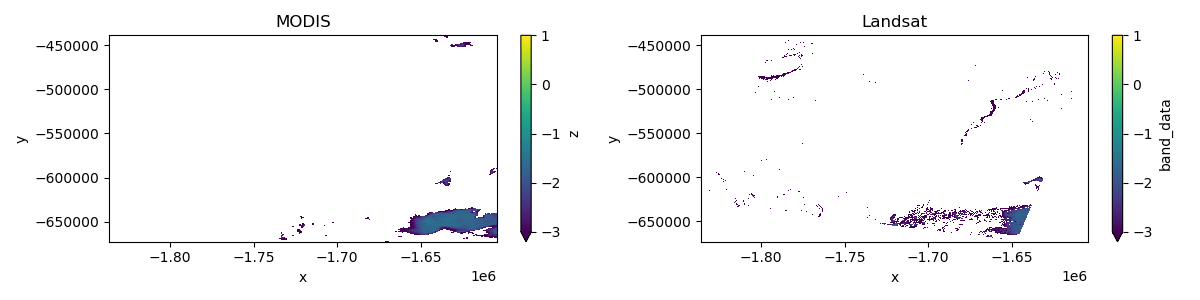

LC08_L1GT_007113_20210926_20210930_02_T2_152914_Cel.tif
31 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
20 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:13


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20210926131501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0


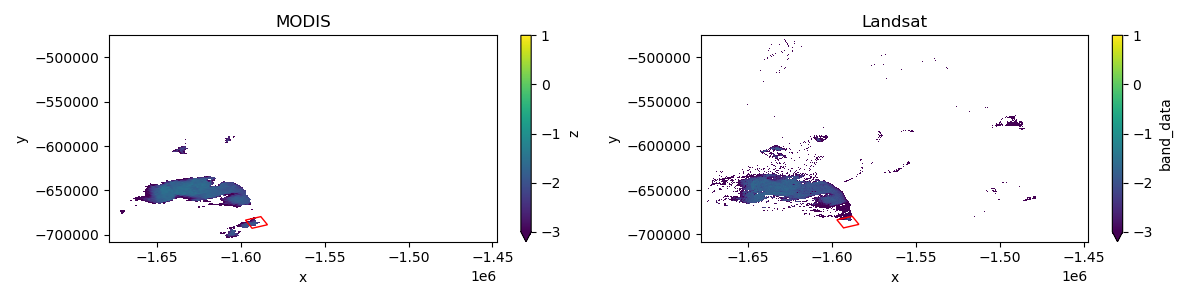

LC08_L1GT_008112_20211120_20211130_02_T2_153502_Cel.tif
31 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
21 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:01


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211120132001-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0


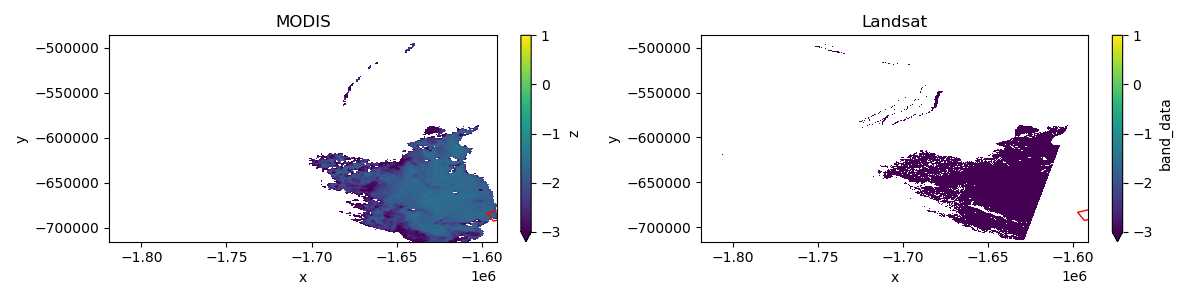

LC08_L1GT_008113_20211120_20211130_02_T2_153526_Cel.tif
31 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
18 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:40:25


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211120100501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0


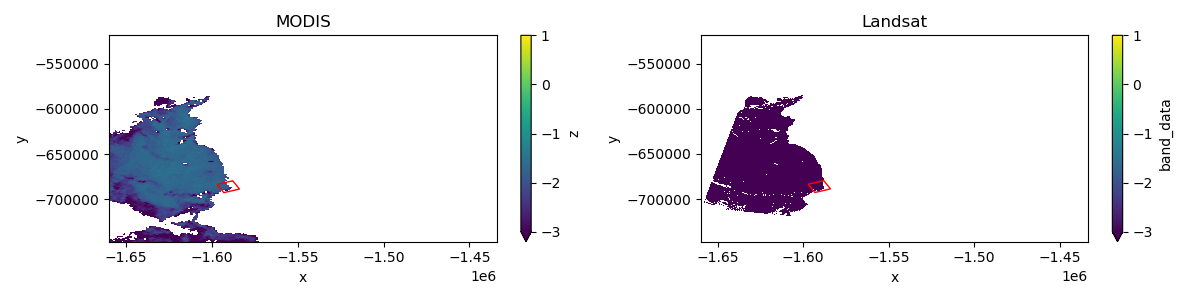

LC08_L1GT_007112_20211129_20211208_02_T2_152853_Cel.tif
28 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
15 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:38:52


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211129082001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0


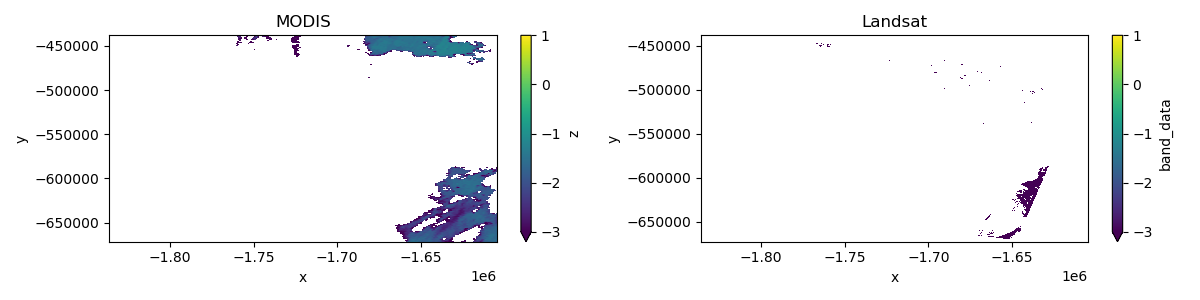

LC08_L1GT_007113_20211129_20211208_02_T2_152917_Cel.tif
28 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
16 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:16


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211129082001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0


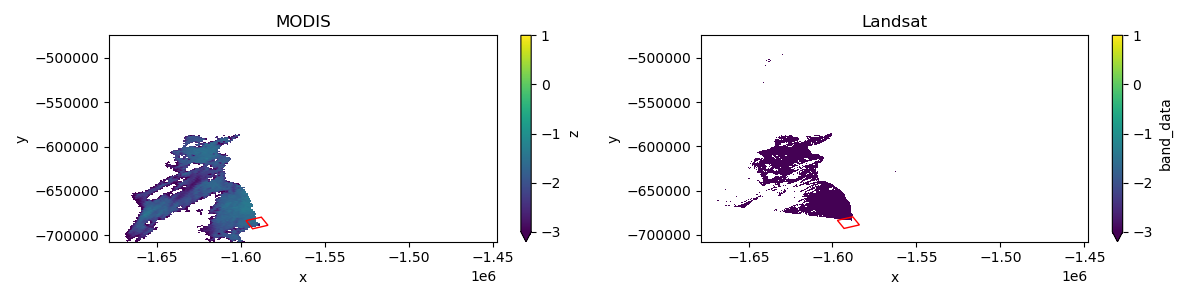

LC08_L1GT_012112_20211202_20211209_02_T2_155947_Cel.tif
30 TOTAL MODIS granules
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
A granule has messed up polygon that likely crosses the International DateLine
17 remaining MODIS granules
Time difference between MODIS and Landsat: 0 days 00:39:46


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

20211202085001-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0


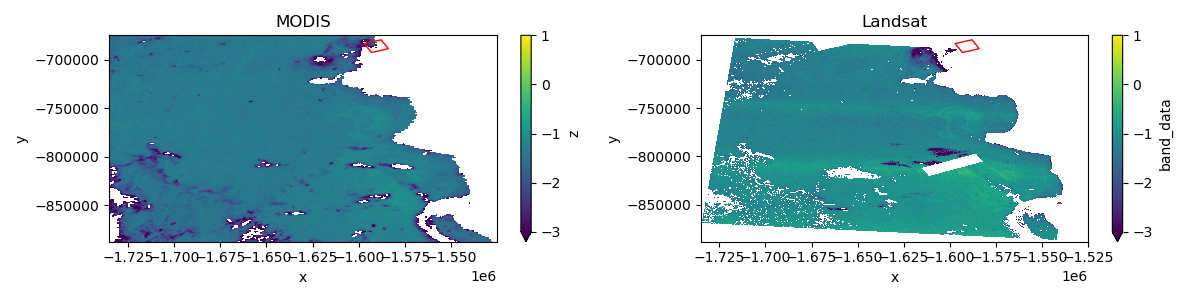

In [60]:
#***Problem is the edge and we think in reprojection from MODIS lookup, so look and see if the new comments come out the same 
#for the bad images and if not, will need to see what the edge issues are in the grid from that functions balltree
# There are artifacts (smearing) at the edges of where MODIS does not overlap with the rest of the Landsat image
lsat_mod = []

for i in range(len(lsatfiles)):
    # Concatenate all landsat files into xarray with a time dimension
    ls_scene = xr.open_dataset(lsatfiles[i],chunks=dict(x=512, y=512),engine='rasterio')['band_data'].sel(band=1)
    ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

    if surf_temp == 'SST':
        times = pd.to_datetime(lsatfiles[i][17:25]+lsatfiles[i][41:47], format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-8])
    elif surf_temp == 'LST':
        times = pd.to_datetime(lsatfiles[i][17:25]+'120000', format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-4])
        ls_scene = ls_scene - 273.15

    lsID = lsatfiles[i]
    print (lsID)

    # Find coincident MODIS SST scene
    mod_scene, mod_file,time_dif = find_MODIS(lonboundsC,latboundsC,ls_scene)
    print(mod_file)

    try:
        # Acquire and align MODIS data to Landsat

        # To subset to only high quality MODIS temp measurements which doesn't seem to be useful
        # print(mod_scene.quality_level.max().values)
        # mod_temps = mod_scene.sea_surface_temperature.where(mod_scene.quality_level>=4)

        MODsst_xr = get_wv(ls_scene,mod_scene.sea_surface_temperature,spacing,param) #mod_scene.sea_surface_temperature

        # Remove SSTs that are unrealistically cool
        # MODsst_xr = MODsst_xr.where(MODsst_xr >= -1.9, np.nan)

        # # Crop Landsat image to meet the slightly smaller MODIS image (smaller image results from upsample methods in get_wv2)
        # ls_scene = subset_img(ls_scene,[MODsst_xr.x.min(),MODsst_xr.x.max()],[MODsst_xr.y.min(),MODsst_xr.y.max()])

        # # Only use MODIS data where cropped Landsat data is also available
        # MODsst_xr_sub = MODsst_xr.where(ls_scene.notnull(),np.nan)

        # # Take mean temp
        # modis = np.nanmean(MODsst_xr_sub)
        # MOD_num = MODsst_xr_sub.notnull().values.sum()
    except Exception as e:
        print (mod_file, e)
        modis = np.nan
        MOD_num = 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    MODsst_xr.plot.imshow(x='x', y='y', vmin=-3, vmax=1, ax=ax1)
    polygon_show1 = Pgon(bbox, closed=True, edgecolor='red', facecolor='none')
    ax1.add_patch(polygon_show1)
    ax1.set_title('MODIS')
    ls_scene.plot.imshow(x='x', y='y', vmin=-3, vmax=1, ax=ax2)
    polygon_show2 = Pgon(bbox, closed=True, edgecolor='red', facecolor='none')
    ax2.add_patch(polygon_show2)
    ax2.set_title('Landsat')
    plt.tight_layout()
    plt.show()

    # try:
    #     del ls_scene, mod_scene, MODsst_xr #ls_sub, MODsst_xr_sub
    # except:
    #     pass

    gc.collect()

    # # Take mean using Landsat data only where cropped MODIS data is also available (need to do both)
    # try:
    #     ls_scene_sub = ls_scene.where(MODsst_xr_sub.notnull(),np.nan)
    #     lsat = np.nanmean(ls_scene_sub)
    #     ls_num = ls_scene_sub.notnull().values.sum()
    # except Exception as e:
    #     print (lsID, e)
    #     lsat = np.nan

    # # Append file names with SST means from the Cosgrove box
    # lsat_mod.append([times,mod_file,modis,MOD_num,lsID,lsat,ls_num,time_dif])
    # print (f'MODIS mean: {modis}, Landsat 8: {lsat}')

## Plot Cosgrove SST timeseries

In [22]:
# For Cosgrove region
out_df = '/home/jovyan/Data/CosgroveBigPlume_SST_20230728' 
cosg = pd.read_pickle(out_df)
# cosg = pd.concat([df1,df2,df3])

# Calibrate the uncalibrated SSTs (for now, will be fixed later)
cosg = cosg.dropna(axis=0)
cosg = cosg.sort_index()

# For Cosgrove small plume
out_df = '/home/jovyan/Data/CosgroveSmallPlume_SST_20230729' 
cosgP = pd.read_pickle(out_df)

# Calibrate the uncalibrated SSTs (for now, will be fixed later)
cosgP = cosgP.dropna(axis=0)
cosgP = cosgP.sort_index()

cosg.head(2)

,L8_filename,L8_SST,count
Datetime,,,
2014-01-12 07:10:57,LC08_L1GT_158132_20140112_20200912_02_T2_07105...,-0.680097,86
2014-01-14 15:04:57,LC08_L1GT_003112_20140114_20201016_02_T2_15045...,-0.749096,3382


In [23]:
# cosgP.sort_values(by=['L8_filename'])

In [24]:
# # QA MODIS and Landsat calibration points
# cosg = cosg[cosg['L8_SST_calib']>=-2.0]
# cosg.head(2)

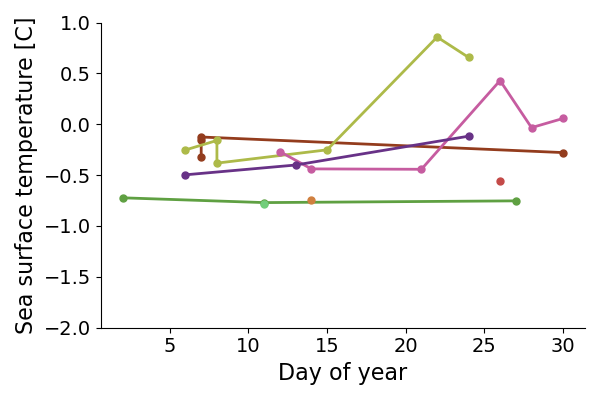

In [25]:
# Plot data points and RANSAC regression
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 4))

data = cosgP

# QC for bad images
data = data[data.L8_filename != 'LC08_L1GT_156132_20160104_20200907_02_T2_065727_Cel'] # clouds

a1 = ax
a1.tick_params(labelsize=14)
a1.plot(data['2023'].index.dayofyear,data['2023']['L8_SST'],color='C8',linewidth=2,marker="o",ms=5,label='2023')
a1.plot(data['2022'].index.dayofyear,data['2022']['L8_SST'],color='k',linewidth=2,marker="o",ms=5,label='2022')
a1.plot(data['2021'].index.dayofyear,data['2021']['L8_SST'],color='r',linewidth=2,marker="o",ms=5,label='2021')
a1.plot(data['2020'].index.dayofyear,data['2020']['L8_SST'],color='C1',linewidth=2,marker="o",ms=5,label='2020')
a1.plot(data['2019'].index.dayofyear,data['2019']['L8_SST'],color='C2',linewidth=2,marker="o",ms=5,label='2019')
a1.plot(data['2018'].index.dayofyear,data['2018']['L8_SST'],color='C3',linewidth=2,marker="o",ms=5,label='2018')
a1.plot(data['2017'].index.dayofyear,data['2017']['L8_SST'],color='C4',linewidth=2,marker="o",ms=5,label='2017')
a1.plot(data['2016'].index.dayofyear,data['2016']['L8_SST'],color='C5',linewidth=2,marker="o",ms=5,label='2016')
a1.plot(data['2015'].index.dayofyear,data['2015']['L8_SST'],color='C6',linewidth=2,marker="o",ms=5,label='2015')
a1.plot(data['2014'].index.dayofyear,data['2014']['L8_SST'],color='C9',linewidth=2,marker="o",ms=5,label='2014')

# a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='r',linewidth=2,label='RANSAC regression')
# a1.plot(xi,xi*resultC.params.MODIS_SST+resultC.params.Intercept,color='k',linewidth=2,label='_no label_')
# a1.text(-2.1,-2.85,'y=0.73x-0.95   p=0.001',fontsize=14)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
a1.set_ylim([-2,1.0])
# a1.set_xlim([-3,2.5])
a1.set_xlabel('Day of year',fontsize=16)
a1.set_ylabel('Sea surface temperature [C]',fontsize=16)
# a1.legend(markerscale=1,fontsize=9,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()

In [ ]:
# # Find MODIS SST scenes - maybe later!
# mod_scenes, mod_files = get_MODIS_SST(bbox,start_dt,end_dt)

# try:
#     # Crop to region and take mean temp, not sure why 0 (MOD09) vs -1 (GHRSST) work here
#     # modis = np.nanmean(mod_reproj.sel(y=slice(latboundsC[1],latboundsC[0]),x=slice(lonboundsC[0],lonboundsC[1])))
#     MODsst_xr_sub = MODsst_xr.sel(y=slice(bbox[1],bbox[1]),x=slice(polarx[0],polarx[1]))
#     if (MODsst_xr_sub.shape[0]>0)&(MODsst_xr_sub.shape[1]>0):
#         # lsat = np.nanmean(ls_reproj.sel(y=slice(latboundsC[1],latboundsC[0]),x=slice(lonboundsC[0],lonboundsC[1])).to_array())
#         modis = np.nanmean(MODsst_xr_sub)
#     elif MODsst_xr_sub.shape[0]==0:
#         print ('MOD y shape is 0')
#         MODsst_xr_sub = MODsst_xr.sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))
#         modis = np.nanmean(MODsst_xr_sub)
#     elif ls_sub.shape[1]==0:
#         print ('MOD x shape is 0')
#         MODsst_xr_sub = MODsst_xr.sel(y=slice(polary[0],polary[1]),x=slice(polarx[1],polarx[0]))
#         modis = np.nanmean(MODsst_xr_sub)
#     print (MODsst_xr_sub.shape)

# except Exception as e:
#     print (mod_file, e)
#     modis = np.nan

# # Append file names with SST means from the Cosgrove box
# lsat_mod.append([mod_file,modis,ls_scene.ID,lsat])
# print (f'MODIS mean: {modis}, Landsat 8: {lsat}')

# try:
#     del ls_scene, ls_sub, mod_scene, MODsst_xr, MODsst_xr_sub
# except:
#     pass